In this notebook we consider the K2 target

- We correct for K2 motion
- We run the corrected light curve and mesured periods through the pymc3 framework to try and model the transits

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
import lightkurve as lk
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
from lightkurve import search_lightcurvefile
from lightkurve import search_lightcurve
from lightkurve import search_targetpixelfile
import exoplanet as xo

In [2]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 18
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True
plt.rcParams['axes.linewidth']=1.5

# Kepler Data

https://exoplanetarchive.ipac.caltech.edu/overview/EPIC%20246711015

In [3]:
star = lk.search_lightcurve('EPIC 246711015',author='EVEREST')
#lk

In [4]:
k2 = star.download_all()

In [5]:
k2

LightCurveCollection of 1 objects:
    0: <KeplerLightCurve LABEL="EPIC 246711015" CAMPAIGN=13 AUTHOR=EVEREST FLUX_ORIGIN=flux>

<AxesSubplot:xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

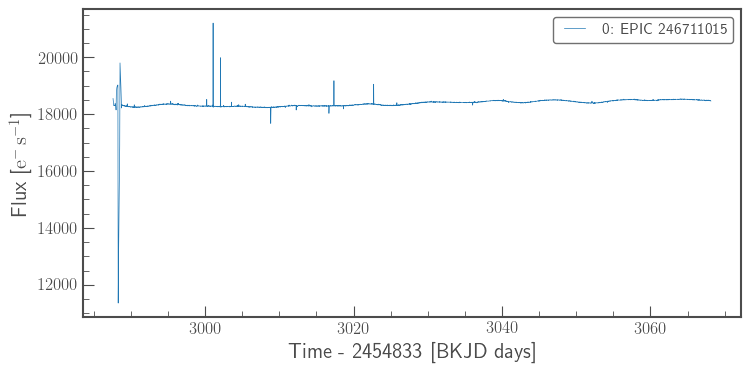

In [6]:
k2.plot()

In [22]:
period1 = 13.284219
period2 = 24.213117

(-2.0, 2.0)

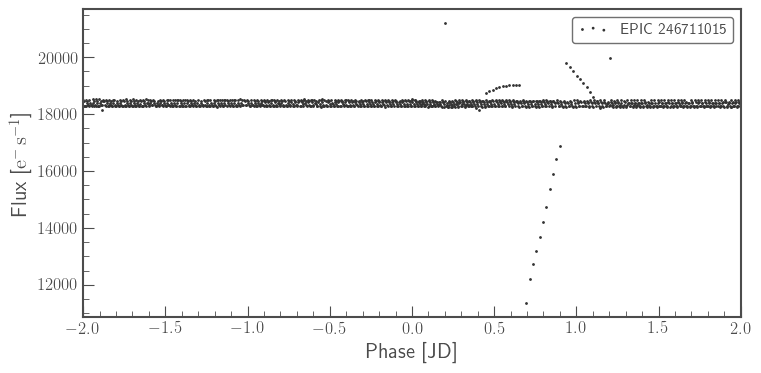

In [42]:
k2[0].fold(period=period1).scatter()
plt.xlim(-2,2)

### We can use the periods measured that are on exofop as a starting point and then throw the corrected light curve into the pymc3 framework to model the transits


https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=k2pandc

In [25]:
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx

In [26]:
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

planet 1 period = 13.284219 +0.002846 -0.001880
planet 2 period = 24.213117 +0.003408 -0.003407

tutorial: https://gallery.exoplanet.codes/tutorials/transit/#the-transit-model-in-pymc3

with stellar variability: https://gallery.exoplanet.codes/tutorials/lc-gp-transit/

In [74]:
periods = [13.284219 , 24.213117]
t0s = periods * np.random.rand(2)

x = k2[0]['time'].value
mu = np.nanmedian(k2[0]['flux'].value)
y = (k2[0]['flux'].value) / mu - 1
yerr =  (np.full((3703),0.01)) / mu
texp = np.median(np.diff(x))

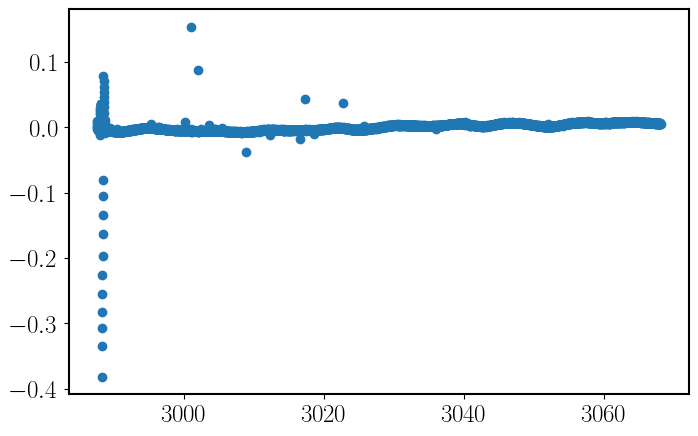

In [49]:
plt.scatter(x,y)


In [43]:
phase_lc = np.linspace(-1, 1, 100)

In [46]:
from astropy import units as units, constants as const

In [75]:
def build_model(mask=None, start=None):

    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    with pm.Model() as model:

        # Shared parameters
        mean = pm.Normal("mean", mu=0, sd=1, testval=0)

        # Stellar parameters.  These are usually determined from spectroscopy
        # and/or isochrone fits.
        logg_star = pm.Normal("logg_star", mu=5.24, sd=0.1440)
        r_star = pm.Normal("r_star", mu=0.1240, sd=0.02)

        # Here "factor" is defined s.t. factor * 10**logg / r_star = rho
        factor = 5.141596357654149e-05
        rho_star = pm.Deterministic(
            "rho_star", factor * 10**logg_star / r_star
        )

        # Limb-darkening: adopt Kipping 2013.
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # To get Rp/R*, fit for log(depth).  This requires an impact parameter
        # prior from 0 to 1, because otherwise there's a sqrt(1-b^2) in the
        # conversion that doesn't make sense.  See
        # https://github.com/exoplanet-dev/exoplanet/blob/e99d1bd68654f21efbbf8400a83889a470d2baf7/src/exoplanet/light_curves/limb_dark.py#L73
        b = pm.Uniform("b", lower=0, upper=1)

        log_depth = pm.Normal("log_depth", mu=np.log(1.8e-3), sigma=1)
        depth = pm.Deterministic("depth", tt.exp(log_depth))

        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(depth, b),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)


        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=120.790, sd=0.02, testval=120.790)
        period = pm.Normal("period", mu=7.203, sd=0.01, testval=7.203)


        # Let the eccentricity float, and use the eccentricity distribution
        # from https://arxiv.org/abs/1807.00549 as our prior.
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.vaneylen19(
            "ecc_prior", multi=False, shape=1, fixed=True, observed=ecc
        )
        # Alternative choice:
        # xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Define the orbit model.
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            b=b,
            rho_star=rho_star,
            r_star=r_star,
            ecc=ecc,
            omega=omega,
        )

        transit_model = mean + tt.sum(
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp),
            axis=-1,
        )

        # Convenience function for plotting.
        pm.Deterministic(
            "transit_pred",
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp),
        )

        # Use the GP model from the stellar variability tutorial at
        # https://gallery.exoplanet.codes/en/latest/tutorials/stellar-variability/

        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sd=2)

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1, 5)
        )
        # Rotation period is 2.6 days, from Lomb Scargle  I don't know the rotation period -- need to calculate
        log_prot = pm.Normal("log_prot", mu=np.log(2.606418), sd=0.02)
        prot = pm.Deterministic("prot", tt.exp(log_prot))
        log_Q0 = pm.Normal("log_Q0", mu=0, sd=2)
        log_dQ = pm.Normal("log_dQ", mu=0, sd=2)
        f = pm.Uniform("f", lower=0.01, upper=1)

        # Set up the Gaussian Process model. See
        # https://celerite2.readthedocs.io/en/latest/tutorials/first/ for an
        # introduction. Here, we have a quasiperiodic term:
        kernel = terms.RotationTerm(
            sigma=sigma_rot,
            period=prot,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f,
        )
        #
        # Note mean of the GP is defined here to be zero, so our "observations"
        # will need to subtract the transit model.  The inverse choice could
        # also be made.
        #
        gp = GaussianProcess(
            kernel,
            t=x[mask],
            diag=yerr[mask] ** 2 + tt.exp(2 * log_jitter),
            quiet=True,
        )

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("transit_obs", observed=y[mask] - transit_model)

        # Compute the GP model prediction for plotting purposes
        pm.Deterministic("gp_pred", gp.predict(y[mask] - transit_model))

        # Track planet radius in Jovian radii
        r_planet = pm.Deterministic(
            "r_planet",
            (ror * r_star) * (1 * units.Rsun / (1 * units.Rjup)).cgs.value,
        )

        # Optimize the MAP solution.
        if start is None:
            start = model.test_point

        map_soln = start

        map_soln = pmx.optimize(
            start=map_soln, vars=[sigma_rot, f, prot, log_Q0, log_dQ]
        )
        map_soln = pmx.optimize(
            start=map_soln,
            vars=[
                log_depth,
                b,
                ecc,
                omega,
                t0,
                period,
                r_star,
                logg_star,
                u_star,
                mean,
            ],
        )
        map_soln = pmx.optimize(start=map_soln)

    return model, map_soln


model, map_estimate = build_model()

optimizing logp for variables: [log_dQ, log_Q0, log_prot, f, sigma_rot]


message: Desired error not necessarily achieved due to precision loss.
logp: 8821.81925225767 -> 12599.952961330357
optimizing logp for variables: [mean, u_star, logg_star, r_star, period, t0, ecs, b, log_depth]


message: Desired error not necessarily achieved due to precision loss.
logp: 12599.952961330357 -> 12606.408393967004
optimizing logp for variables: [f, log_dQ, log_Q0, log_prot, sigma_rot, log_jitter, ecs, period, t0, log_depth, b, u_star, r_star, logg_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: 12606.408393967004 -> 12606.502692726306


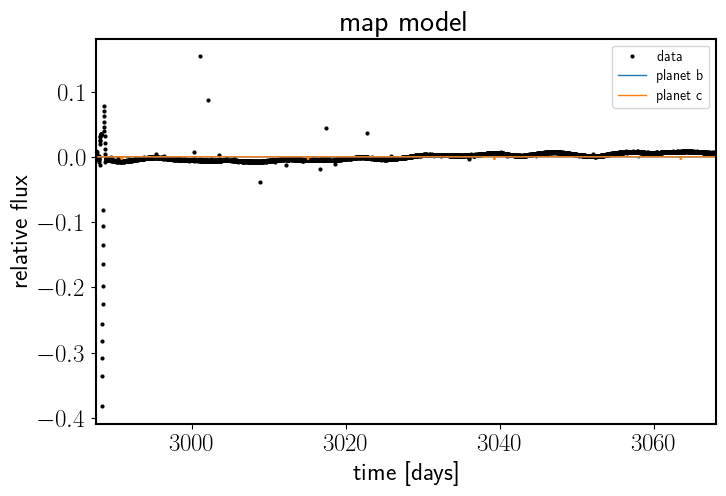

In [76]:
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

In [80]:
def plot_light_curve(x, y, soln, mask=None):

    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    plt.close("all")
    fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

    ax = axes[0]

    if len(x[mask]) > int(2e4):
        # see https://github.com/matplotlib/matplotlib/issues/5907
        mpl.rcParams["agg.path.chunksize"] = 10000

    ax.scatter(
        x[mask],
        y[mask],
        c="k",
        s=0.5,
        rasterized=True,
        label="data",
        linewidths=0,
        zorder=42,
    )
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(
        x[mask], gp_mod, color="C2", label="MAP gp model", zorder=41, lw=0.5
    )
    ax.legend(fontsize=10)
    ax.set_ylabel("$f$")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="data - MAPgp")
    for i, l in enumerate("b"):
        mod = soln["transit_pred"][:, i]
        ax.plot(
            x[mask],
            mod,
            label="planet {0} [model under]".format(l),
            zorder=-10,
        )
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("$f_\mathrm{dtr}$")

    ax = axes[2]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="data - MAPgp")
    for i, l in enumerate("b"):
        mod = soln["transit_pred"][:, i]
        ax.plot(x[mask], mod, label="planet {0} [model over]".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("$f_\mathrm{dtr}$ [zoom]")
    ymin = np.min(mod) - 0.05 * abs(np.min(mod))
    ymax = abs(ymin)
    ax.set_ylim([ymin, ymax])

    ax = axes[3]
    mod = gp_mod + np.sum(soln["transit_pred"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")

    fig.tight_layout()

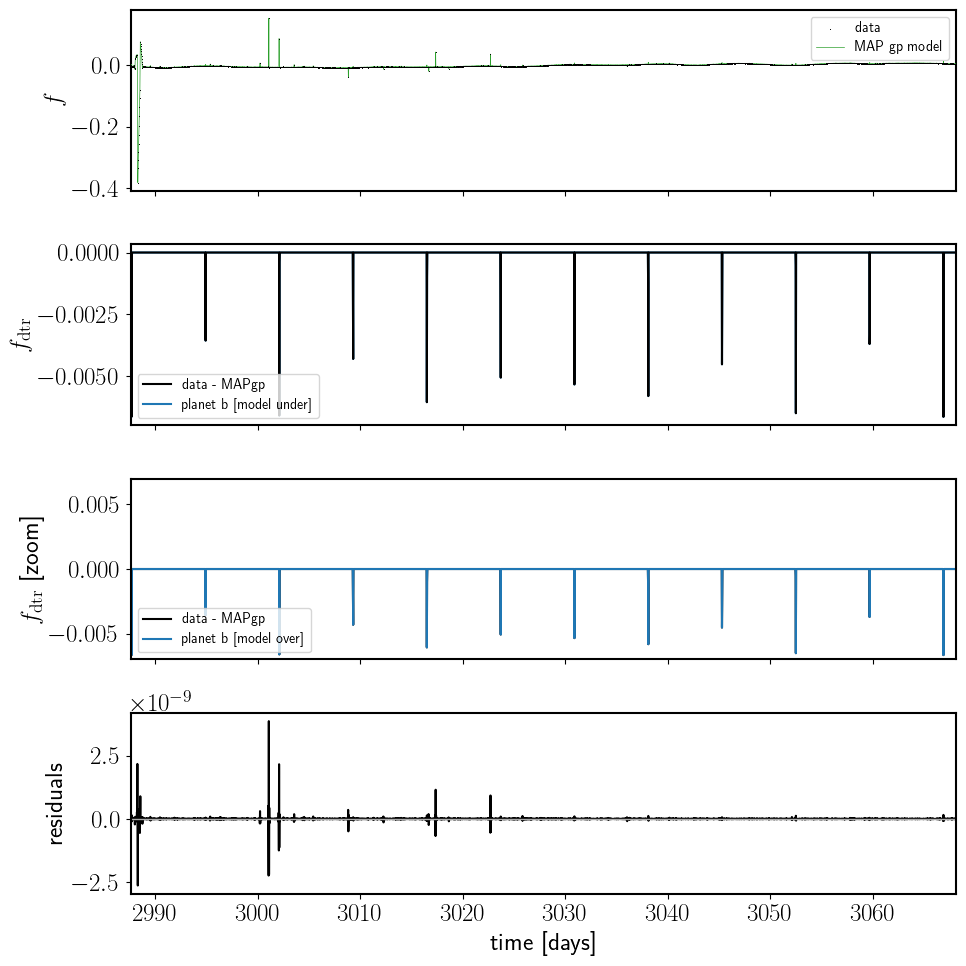

In [81]:
plot_light_curve(x, y, map_estimate)

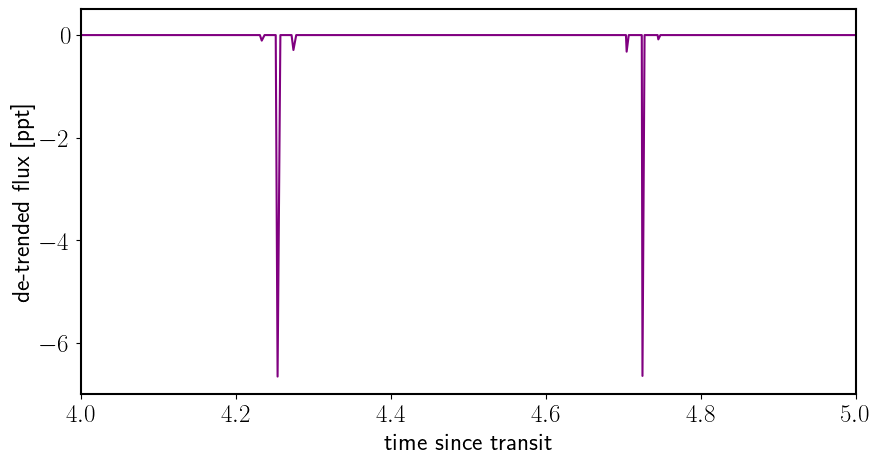

In [106]:
# Plot the folded transit
fig, ax = plt.subplots(figsize=(10, 5))

# Ephemeris from Holczer+16
t0 = t0s[0]
period = period1

x_fold = (x - t0 + 0.5 * period) % period - 0.5 * period
m = np.abs(x_fold) < 0.5
ax.scatter(
    x_fold[m],
    1e3 * (y[m] - map_estimate["gp_pred"][m]),
    c="k",
    marker=".",
    alpha=0.9,
    linewidths=0,
)

lc_mod = map_estimate["transit_pred"][:, 0]
lc_modx = np.sort(x_fold)
lc_mody = lc_mod[np.argsort(x_fold)]
ax.plot(lc_modx, 1e3 * (lc_mody + map_estimate["mean"]), c="purple", zorder=1)

# Overplot the phase binned light curve
bins = np.linspace(-0.51, 0.51, 100)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y - map_estimate["gp_pred"])
denom[num == 0] = 1.0
#ax.scatter(
    #0.5 * (bins[1:] + bins[:-1]),
    #1e3 * num / denom,
    #color="C1",
    #zorder=2,
    #linewidths=0,
#)

ax.set_xlim(4,5)
ax.set_ylim(-7, 0.5)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")

In [95]:
params = (
    "mean,logg_star,r_star,period,t0,log_depth,b,log_jitter,log_prot"
    ",log_Q0,log_dQ,r_star,rho_star,depth,ror,sigma_rot,prot,f,r_planet".split(
        ","
    )
)
for p in params:
    print(f"{p}: {map_estimate[p]:.5f}")


mean: 0.00000
logg_star: 5.29987
r_star: 0.11981
period: 7.20325
t0: 120.78999
log_depth: -4.87141
b: 0.81155
log_jitter: -14.42372
log_prot: 0.97056
log_Q0: -6.97038
log_dQ: -1.75354
r_star: 0.11981
rho_star: 85.59849
depth: 0.00766
ror: 0.09066
sigma_rot: 0.06773
prot: 2.63941
f: 0.01023
r_planet: 0.10571


In [96]:
print(f"jitter is {np.exp(map_estimate['log_jitter'])*1e3:.2f} ppt")
print(f"mean(yerr) is {np.mean(yerr)*1e3:.2f} ppt")

jitter is 0.00 ppt
mean(yerr) is 0.00 ppt
